In [1]:
import lancedb
import langchain
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import LanceDB
from langchain.chat_models import ChatOpenAI
from langgraph.graph import StateGraph, END, START
from langchain.schema import SystemMessage, HumanMessage
from typing import List, Dict
import logging


i:\AI_Project\chatbot_agent\Langgraph-Tutorial\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from langchain_openai import ChatOpenAI
import os
from pydantic import BaseModel, Field

logging.basicConfig(format="%(asctime)s - %(message)s", level=logging.INFO)

llm = ChatOpenAI(
    model= "gpt-4o-mini",
    api_key= os.environ["GITHUB_API_KEY"],
    base_url= "https://models.inference.ai.azure.com",
)

TOGETHER_AI_BASE_URL = "https://api.together.xyz/v1"
llama3_3_chat = ChatOpenAI(
    model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
    base_url=TOGETHER_AI_BASE_URL,
    api_key=os.environ["TOGETHERAI_API_KEY"]
)

class StateDefinition(BaseModel):
    name: str = Field(..., title="State Name")
    defaultValue: str = Field(..., title="Default Value")

# Define Agent State
class AgentState(BaseModel):
    query: str
    is_relevant: bool = True
    tasks: List[str] = []
    retrieved_jsx: Dict[str, str] = {}
    generated_code: Dict[str, str] = {}
    stateList: List[StateDefinition] = []

In [3]:
from lancedb.embeddings import get_registry
embedding_model = get_registry().get("sentence-transformers").create(name="BAAI/bge-small-en-v1.5")

#You should put HF_TOKEN in the Notebook enviroment variables
from lancedb.pydantic import LanceModel, Vector

# Connect to LanceDB (Vector Database for JSX Retrieval)
db = lancedb.connect(".lancedb")  
# vector_store = LanceDB(db, OpenAIEmbeddings())

data = [
    {
        "elementType":"div",
        "jsx": '<div>hello world</div>',
    },
    {
        "elementType":"span",
        "jsx": '<span>hello world</span>',
    },
    {
        "elementType":"a",
        "jsx": '<a>hello world</a>',
    }
]

class ChunksOfData(LanceModel):
    elementType: str = embedding_model.SourceField()
    jsx: str
    vector: Vector(embedding_model.ndims()) = embedding_model.VectorField()

tbl = db.create_table(
    "react_elements",
    data= data,
    schema=ChunksOfData,
    exist_ok=True
)

2025-02-07 16:41:46,676 - Load pretrained SentenceTransformer: BAAI/bge-small-en-v1.5
Batches: 100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


In [4]:
tbl = db.open_table("react_elements")
query = "div"

res= tbl.search(query).limit(1).to_pandas()
res

Batches: 100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


,elementType,jsx,vector,_distance
0,div,<div>hello world</div>,"[-0.027646223, -0.043133184, 0.033710644, -0.0...",0.0


In [5]:
from pydantic import BaseModel, Field

class RelevantUserQuery(BaseModel):
    is_relevant : bool = Field(description="boolean for relevance or not")

# **Relevance Check Node**
def check_relevance(state: AgentState):
    prompt = f"Is the following request related to front-end UI component generation? \n\nQuery: {state.query}"
    
    structured_model = llm.with_structured_output(RelevantUserQuery)
    
    response = structured_model.invoke([SystemMessage(content="You determine if a query is relevant to UI development."),
                           HumanMessage(content=prompt)])
        
    logging.info(f"Relevance Check Response: {response.is_relevant}")
    
    state.is_relevant = response.is_relevant
    return state

In [6]:
from pydantic import BaseModel, Field

class TaskList(BaseModel):
    tasks : List[str] = Field(description="list of tasks")

# **Task Processing Node**
def process_query(state: AgentState):
    prompt = f"{state.query}"

    structured_model = llm.with_structured_output(TaskList)
    response = structured_model.invoke([SystemMessage(content="""You analyze UI queries and generate structured tasks.
                                                      you are assistant for craete jsx code but in mullti step process.
                                                      you should generate each of tag element with style and attributes recursively.

                                                      for done this recursively you should the user query divide to some task and do it step by step.
                                                      now create sub task of user query for generate jsx code for each tag element recursively.
                                                      """),
                           HumanMessage(content=prompt)])
    
    logging.info(f"Task Processing Response: {response.tasks}\n ======================================= \n")
    state.tasks = response.tasks  # Convert response to a list
    return state

In [7]:
# **Retrieve JSX from LanceDB**
def retrieve_jsx(state: AgentState):
    for task in state.tasks:
        results = tbl.search(task).limit(1).to_list()

        logging.info(f"Retrieved JSX for task '{task}': {results[0]['jsx'] if results else 'None'}")
        state.retrieved_jsx[task] = results[0]["jsx"] if results else "<div></div>"
    return state

In [8]:
from pydantic import BaseModel, Field

class JsxTask(BaseModel):
    jsx : str = Field(description="jsx code")

# **Generate JSX Using LLM**
def generate_code(state: AgentState):
    for task, retrieved_jsx in state.retrieved_jsx.items():
        prompt = f"""Modify the following JSX to match this task requirement:\n\n
        Task: {task}\n\nRetrieved JSX:\n{retrieved_jsx}\n\n
        Ensure minimal and structured JSX.
        """
        structured_model = llm.with_structured_output(JsxTask)
        
        response = structured_model.invoke([SystemMessage(content="You refine JSX to match UI tasks."),
                               HumanMessage(content=prompt)])
        
        logging.info("Generated JSX for task '{}': {}".format(task, response.jsx))
        state.generated_code[task] = response.jsx
    return state

In [9]:
class FinalResult(BaseModel):
    jsx : str = Field(description="only jsx code return here,not react component")
    stateDefinitionList: List[StateDefinition] = Field(description="list of state definition")

# **Merge All JSX into a Final Component**
def merge_code(state: AgentState):
    # elements = "\n".join(state.generated_code.values())
    prompt = f"""the user query is: {state.query}.\n\n 
    at the first we break the user query to sub tasks and recusive generate jsx code for each of them, this is of sub task and
    generataed jsx: {state.generated_code}.
    now i want base on sub generated code and task, you generate complete jsx of user query.
    note: response that you generate must be only based on sub generated code and task.
    if this jsx need to define state you should define it in stateList. and can be used in jsx code
    """
    
    structured_model = llm.with_structured_output(FinalResult)
    response = structured_model.invoke([SystemMessage(content="You combine JSX elements into a structured jsx."),
                           HumanMessage(content=prompt)])
    state.stateList = state.stateList + (response.stateDefinitionList if response.stateDefinitionList else [])
    
    logging.info("Final Generated React jsx : {}".format(response.jsx))
    return state

In [10]:
from typing import Literal

def decide_mood(state) -> Literal["process_query", END]:
    # Often, we will use state to decide on the next node to visit
    if state.is_relevant == True:
        return "process_query"
    
    else:
        return END

In [11]:
# **Define Graph Workflow**
workflow = StateGraph(AgentState)

# Add Nodes
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("process_query", process_query)
workflow.add_node("retrieve_jsx", retrieve_jsx)
workflow.add_node("generate_code", generate_code)
workflow.add_node("merge_code", merge_code)

workflow.add_edge(START, "check_relevance")

# **Conditional Edge:**
workflow.add_conditional_edges(
    "check_relevance",  # From
    decide_mood
)

# Normal Edges
workflow.add_edge("process_query", "retrieve_jsx")
workflow.add_edge("retrieve_jsx", "generate_code")
workflow.add_edge("generate_code", "merge_code")
workflow.add_edge("merge_code", END)

# Compile and Run
graph = workflow.compile()

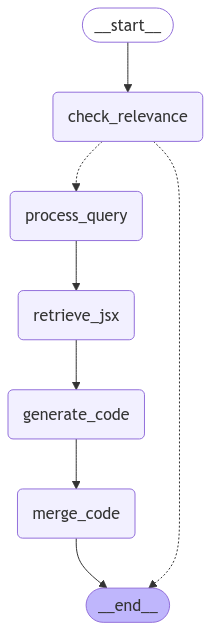

In [12]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
initial_stateee = AgentState(query="I want one stepper ui by two step, in step one exist input and checkbox fot name and sex of user and in step two there are many input for address ,age and phone number")

graph.invoke(initial_stateee)

2025-02-07 16:42:04,334 - HTTP Request: POST https://models.inference.ai.azure.com/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-02-07 16:42:04,340 - Retrying request to /chat/completions in 0.419063 seconds
2025-02-07 16:42:05,026 - HTTP Request: POST https://models.inference.ai.azure.com/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-02-07 16:42:05,028 - Retrying request to /chat/completions in 0.985774 seconds
2025-02-07 16:42:06,280 - HTTP Request: POST https://models.inference.ai.azure.com/chat/completions "HTTP/1.1 429 Too Many Requests"


RateLimitError: Error code: 429 - {'error': {'code': 'RateLimitReached', 'message': 'Rate limit of 150 per 86400s exceeded for UserByModelByDay. Please wait 70911 seconds before retrying.', 'details': 'Rate limit of 150 per 86400s exceeded for UserByModelByDay. Please wait 70911 seconds before retrying.'}}